In [1]:
import collections
import dataclasses

import networkx as nx
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

from scripture_graph import graph_lib
from scripture_graph import notebook_lib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
graph = nx.read_graphml("../../../scripture_graph.graphml")
graph_lib.remove_suggested_edges(graph)
print(nx.info(graph))

Name: 
Type: DiGraph
Number of nodes: 48566
Number of edges: 183072
Average in degree:   3.7696
Average out degree:   3.7696


In [3]:
# Make a copy without the topic nodes.
original_graph = graph.copy()
graph_lib.remove_topic_nodes(original_graph)

48566 183072
41995 45985


In [4]:
def analyze_graph(graph):
    rows = []
    for node in graph.nodes:
        if graph.nodes[node]["kind"] == "topic":
            row = graph.nodes[node]
            row["key"] = node
            rows.append(row)
    topics = pd.DataFrame(rows)
    print("NODES")
    print("topics")
    print(topics.source.value_counts())
    print("other", graph.number_of_nodes() - len(topics))
    print("total", graph.number_of_nodes())

    rows = []
    for source, target in graph.edges:
        row = {"source": source, "target": target}
        row.update({f"source_{key}": value for key, value in graph.nodes[source].items()})
        row.update({f"target_{key}": value for key, value in graph.nodes[target].items()})
        rows.append(row)
    edges = pd.DataFrame(rows)
    topic_topic = (edges.source_kind == "topic") & (edges.target_kind == "topic")
    topic_verse = (edges.source_kind == "topic") & (edges.target_kind == "verse")
    verse_topic = (edges.source_kind == "verse") & (edges.target_kind == "topic")
    verse_verse = (edges.source_kind == "verse") & (edges.target_kind == "verse")

    print("EDGES")
    print("topic->verse", topic_verse.sum())
    print("verse->topic", verse_topic.sum())
    print("verse->verse", verse_verse.sum())
    print("topic->topic", topic_topic.sum())
    print("total", graph.number_of_edges())
    assert topic_verse.sum() + verse_topic.sum() + verse_verse.sum() + topic_topic.sum() == graph.number_of_edges()

In [5]:
analyze_graph(graph)

NODES
topics
TG     3512
ITC    3059
Name: source, dtype: int64
other 41995
total 48566
EDGES
topic->verse 100597
verse->topic 22223
verse->verse 45985
topic->topic 14267
total 183072


# Repeat previous analysis

In [6]:
rows = []
for node, degree in graph.in_degree():
    if graph.nodes[node]["kind"] != "verse":
        continue
    row = {"node": node, "degree": degree, "subset": "with_topics"}
    row.update(graph.nodes[node])
    rows.append(row)
    row = {"node": node, "degree": original_graph.in_degree(node), "subset": "without_topics"}
    row.update(graph.nodes[node])
    rows.append(row)
degree = pd.DataFrame(rows)
print(degree.shape)
degree.head()

(83990, 8)


,node,degree,subset,kind,volume,book,chapter,verse
0,1 Chr. 1:1,0,with_topics,verse,Old Testament,1 Chr.,1,1
1,1 Chr. 1:1,0,without_topics,verse,Old Testament,1 Chr.,1,1
2,1 Chr. 1:2,0,with_topics,verse,Old Testament,1 Chr.,1,2
3,1 Chr. 1:2,0,without_topics,verse,Old Testament,1 Chr.,1,2
4,1 Chr. 1:3,0,with_topics,verse,Old Testament,1 Chr.,1,3


In [7]:
mask = degree.subset == "with_topics"

In [8]:
alone = (degree[mask].degree == 0).sum()
alone / len(degree[mask])

0.30927491368020005

In [9]:
count = (degree[mask].degree >= 1) & (degree[mask].degree <= 5)
count.sum() / len(degree[mask])

0.4804143350398857

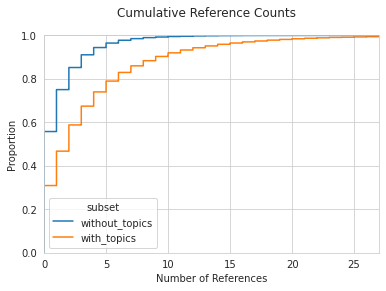

In [10]:
sns.set_style("whitegrid")

fig, ax = subplots()
sns.ecdfplot(data=degree, x="degree", hue="subset", hue_order=["without_topics", "with_topics"], ax=ax)
suptitle("Cumulative Reference Counts")
ax.set_xlabel("Number of References")
ax.set_xlim(0, 27)
fig.savefig("count-cdf.png", dpi=300, bbox_inches="tight")

In [11]:
volume_totals = collections.defaultdict(int)
for node in graph.nodes:
    volume_totals[graph.nodes[node]["volume"]] += 1
del volume_totals["Study Helps"]
volume_totals

defaultdict(int,
            {'Old Testament': 23145,
             'New Testament': 7957,
             'Book of Mormon': 6604,
             'Pearl of Great Price': 635,
             'Doctrine and Covenants': 3654})

In [12]:
volume_degree_without_topics = {}
for key in volume_totals:
    mask = (degree.subset == "without_topics") & (degree.volume == key)
    volume_degree_without_topics[key] = degree[mask].degree.values.sum()
volume_degree_without_topics

{'Old Testament': 17017,
 'New Testament': 7260,
 'Book of Mormon': 12278,
 'Pearl of Great Price': 1435,
 'Doctrine and Covenants': 7995}

In [13]:
relative_volume_degree_without_topics = {}
for key in volume_totals:
    relative_volume_degree_without_topics[key] = volume_degree_without_topics[key] / volume_totals[key]
relative_volume_degree_without_topics

{'Old Testament': 0.7352343918772953,
 'New Testament': 0.9124041724267941,
 'Book of Mormon': 1.8591762568140522,
 'Pearl of Great Price': 2.2598425196850394,
 'Doctrine and Covenants': 2.1880131362889985}

In [14]:
volume_degree_with_topics = {}
for key in volume_totals:
    mask = (degree.subset == "with_topics") & (degree.volume == key)
    volume_degree_with_topics[key] = degree[mask].degree.values.sum()
volume_degree_with_topics

{'Old Testament': 36589,
 'New Testament': 29048,
 'Book of Mormon': 43602,
 'Pearl of Great Price': 6011,
 'Doctrine and Covenants': 31332}

In [15]:
relative_volume_degree_with_topics = {}
for key in volume_totals:
    relative_volume_degree_with_topics[key] = volume_degree_with_topics[key] / volume_totals[key]
relative_volume_degree_with_topics

{'Old Testament': 1.5808597969323828,
 'New Testament': 3.6506220937539275,
 'Book of Mormon': 6.602362204724409,
 'Pearl of Great Price': 9.466141732283464,
 'Doctrine and Covenants': 8.574712643678161}

In [16]:
delta_degree = {}
for key, value in volume_degree_with_topics.items():
    delta_degree[key] = value - volume_degree_without_topics[key]
delta_degree

{'Old Testament': 19572,
 'New Testament': 21788,
 'Book of Mormon': 31324,
 'Pearl of Great Price': 4576,
 'Doctrine and Covenants': 23337}

In [17]:
relative_delta_degree = {}
for key, value in relative_volume_degree_with_topics.items():
    relative_delta_degree[key] = value - relative_volume_degree_without_topics[key]
relative_delta_degree

{'Old Testament': 0.8456254050550874,
 'New Testament': 2.7382179213271334,
 'Book of Mormon': 4.743185947910357,
 'Pearl of Great Price': 7.2062992125984255,
 'Doctrine and Covenants': 6.386699507389163}

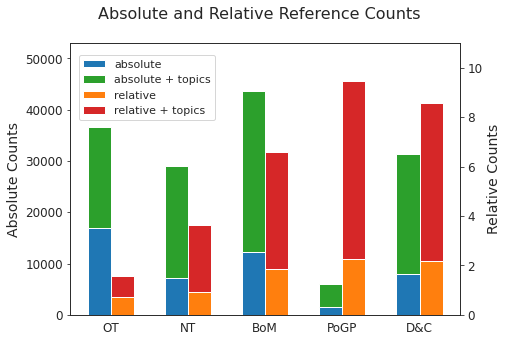

In [18]:
sns.set_style("white")
colors = sns.color_palette()
fig, ax = subplots(figsize=(7, 5))
ax.bar(range(5), volume_degree_without_topics.values(), color=colors[0], label="absolute", width=-0.3, align="edge")
ax.bar(
    range(5),
    delta_degree.values(),
    bottom=list(volume_degree_without_topics.values()),
    color=colors[2],
    label="absolute + topics",
    width=-0.3,
    align="edge",
)
ax.set_ylabel("Absolute Counts", fontsize=14)
ax2 = ax.twinx()
ax2.bar(
    range(5), relative_volume_degree_without_topics.values(), color=colors[1], label="relative", width=0.3, align="edge"
)
ax2.bar(
    range(5),
    relative_delta_degree.values(),
    bottom=list(relative_volume_degree_without_topics.values()),
    color=colors[3],
    label="relative + topics",
    width=0.3,
    align="edge",
)
ax2.set_ylabel("Relative Counts", fontsize=14)
ax.tick_params(axis="y", labelsize=12)
ax2.tick_params(axis="y", labelsize=12)
ax.set_xticks(range(5))
ax.set_xticklabels([graph_lib.VOLUMES_SHORT[key] for key in volume_degree_without_topics], fontsize=12)
ax.set_ylim(0, 53000)
ax2.set_ylim(0, 11)
# figlegend(loc=(0.23, 0.674), fontsize=10)
figlegend(loc=(0.155, 0.648), fontsize=11)
suptitle("Absolute and Relative Reference Counts", fontsize=16)
fig.savefig("count-bar.png", dpi=300, bbox_inches="tight")

# Get the largest subgraph

In [19]:
sizes = []
for component in nx.weakly_connected_components(graph):
    sizes.append(len(component))
sizes = np.asarray(sizes)

x = np.unique(sizes)
y = np.asarray([np.count_nonzero(sizes == size) for size in x])
df = pd.DataFrame({"size": x, "count": y})
df

,size,count
0,1,12943
1,2,287
2,3,59
3,4,14
4,5,7
5,6,1
6,7,2
7,11,2
8,34739,1


In [20]:
# Prune the graph to the largest weakly connected component.
nodes = None
for component in nx.weakly_connected_components(graph):
    if len(component) > 1000:
        nodes = component
        break
subgraph = nx.subgraph(graph, nodes)
print(graph.number_of_nodes())
print(graph.number_of_edges())
print(subgraph.number_of_nodes())
print(subgraph.number_of_edges())

48566
183072
34739
182096


In [21]:
# Percentage of singletons (no incoming *or* outgoing edges)
count = 0
for node, degree in graph.degree():
    if degree == 0:
        count += 1
print(count, count / graph.number_of_nodes())

12943 0.2665033150763909


In [22]:
# Percentage of non-singletons in the largest component.
print(subgraph.number_of_nodes() / (graph.number_of_nodes() - count))

0.9751845717654325


In [23]:
# Percentage of nodes.
print(subgraph.number_of_nodes() / graph.number_of_nodes())

0.7152946505785941


In [24]:
# Percentage of verses.
count = 0
total = 0
for node in graph.nodes:
    if graph.nodes[node]["kind"] != "verse":
        continue
    total += 1
    if node in subgraph.nodes:
        count += 1
print(count, total, count / total)

28573 41995 0.6803905226812715


In [25]:
# Percentage of edges.
print(subgraph.number_of_edges() / graph.number_of_edges())

0.9946687642020626


In [26]:
analyze_graph(subgraph)

NODES
topics
TG     3180
ITC    2986
Name: source, dtype: int64
other 28573
total 34739
EDGES
topic->verse 100537
verse->topic 22223
verse->verse 45070
topic->topic 14266
total 182096


# Centrality and link analysis

In [27]:
degree_df = notebook_lib.assign_ranks(nx.in_degree_centrality(subgraph))

In [28]:
pagerank_df = notebook_lib.assign_ranks(nx.pagerank(subgraph))

In [29]:
merged = degree_df.merge(pagerank_df, on="key", suffixes=("_degree", "_pagerank"))
assert len(merged) == len(degree_df) == len(pagerank_df)
topk = set(merged.key.values[:10])
topk.update(set(merged.sort_values("rank_pagerank").key.values[:10]))
merged[merged.key.isin(topk)]

,key,score_degree,rank_degree,score_pagerank,rank_pagerank
0,TG Faith,0.004145,1,0.000933,1
1,TG Righteousness,0.004145,1,0.000899,2
2,"TG Repent, Repentance",0.004059,3,0.000734,11
3,"TG Prayer, Pray",0.003915,4,0.000822,5
4,"TG Obedience, Obedient, Obey",0.003541,5,0.000612,30
5,TG Sin,0.003397,6,0.000623,27
6,"TG Jesus Christ, Prophecies about",0.003310,7,0.000855,4
7,"TG Jesus Christ, Atonement through",0.003224,8,0.000674,20
8,"TG Forgive, Forgiveness",0.003138,9,0.000720,12
9,"TG God, Spirit of",0.003023,10,0.000717,13


In [30]:
mask = merged.key.str.startswith(("TG", "ITC"))

merged.loc[~mask, "rank_degree_adjusted"] = scipy.stats.rankdata(-1 * merged[~mask].score_degree.values, method="min")
merged.loc[~mask, "rank_pagerank_adjusted"] = scipy.stats.rankdata(
    -1 * merged[~mask].score_pagerank.values, method="min"
)

topk = set(merged[~mask].key.values[:10])
topk.update(set(merged[~mask].sort_values("rank_pagerank").key.values[:10]))
merged[merged.key.isin(topk)]

,key,score_degree,rank_degree,score_pagerank,rank_pagerank,rank_degree_adjusted,rank_pagerank_adjusted
145,D&C 132:19,0.001641,146,0.000166,566,1.0,41.0
150,Moses 6:57,0.001612,151,0.000235,386,2.0,6.0
158,1 Ne. 19:10,0.001583,159,0.000227,406,3.0,7.0
159,D&C 13:1,0.001583,159,0.000215,433,3.0,12.0
160,Mosiah 3:19,0.001583,159,0.000242,366,3.0,4.0
168,D&C 17:1,0.001554,169,0.000261,326,6.0,1.0
179,1 Ne. 17:35,0.001526,180,0.000222,416,7.0,9.0
180,Mosiah 3:5,0.001526,180,0.000180,523,7.0,28.0
191,Mosiah 4:26,0.001497,192,0.000251,345,9.0,3.0
211,D&C 1:16,0.001439,212,0.000200,471,10.0,15.0


In [31]:
mask = merged.key.isin(["2 Ne. 25:20", "D&C 88:63", "2 Ne. 9:37"])
merged[mask]

,key,score_degree,rank_degree,score_pagerank,rank_pagerank,rank_degree_adjusted,rank_pagerank_adjusted
226,2 Ne. 25:20,0.001382,227,0.000184,507,14.0,25.0
374,D&C 88:63,0.001094,372,0.000210,445,43.0,13.0
1719,2 Ne. 9:37,0.000489,1692,0.000138,648,1087.0,87.0


## Hubs and authorities

In [32]:
hubs, authorities = nx.hits(subgraph, max_iter=1000)

In [33]:
hub_df = notebook_lib.assign_ranks(hubs)
hub_df.head(10)

,key,score,rank
0,ITC God,0.004818,1
1,ITC Jesus Christ,0.003994,2
2,TG Spirit,0.003209,3
3,ITC Name of the Lord,0.002814,4
4,ITC Jesus Christ—Son of God,0.002726,5
5,"TG Know, Knew, Known",0.002464,6
6,"ITC Repentance, Repent",0.002420,7
7,"ITC Spirit, Holy/Spirit of the Lord",0.002286,8
8,"TG Power, Powerful",0.002031,9
9,ITC Faith,0.002016,10


In [34]:
hub_df[~hub_df.key.str.startswith(("TG", "ITC"))].head(10)

,key,score,rank
500,1 Ne. 19:10,0.000318,501
540,Moses 6:57,0.000299,541
555,2 Ne. 26:12,0.000296,556
631,Gen. 2:7,0.000269,632
671,Gen. 1:26,0.000255,672
681,Moses 1:39,0.000252,682
686,Moses 1:6,0.000251,687
700,D&C 76:24,0.000247,701
746,Mosiah 3:19,0.000236,747
757,Mosiah 15:2,0.000233,758


In [35]:
authority_df = notebook_lib.assign_ranks(authorities)
authority_df.head(10)

,key,score,rank
0,2 Ne. 31:21,0.000731,1
1,Moses 6:57,0.000727,2
2,Isa. 9:6,0.000721,3
3,D&C 68:25,0.000711,4
4,Moro. 10:4,0.000699,5
5,Jacob 4:5,0.000688,6
6,2 Ne. 19:6,0.000676,7
7,D&C 13:1,0.000625,8
8,"TG Repent, Repentance",0.000613,9
9,Moses 6:59,0.000605,10


In [36]:
authority_df[~authority_df.key.str.startswith(("TG", "ITC"))].head(10)

,key,score,rank
0,2 Ne. 31:21,0.000731,1
1,Moses 6:57,0.000727,2
2,Isa. 9:6,0.000721,3
3,D&C 68:25,0.000711,4
4,Moro. 10:4,0.000699,5
5,Jacob 4:5,0.000688,6
6,2 Ne. 19:6,0.000676,7
7,D&C 13:1,0.000625,8
9,Moses 6:59,0.000605,10
10,D&C 20:37,0.000601,11


In [37]:
mask = authority_df.key.isin(
    [
        "Mosiah 7:19",
        "1 Ne. 19:10",
        "2 Ne. 25:20",
        "Mosiah 7:27",
        "2 Ne. 26:12",
        "Alma 11:39",
        "2 Ne. 10:3",
        "3 Ne. 11:14",
        "D&C 19:27",
        "1 Ne. 13:42",
    ]
)
authority_df[mask]

,key,score,rank
26,Mosiah 7:27,0.000471,27
42,3 Ne. 11:14,0.000426,43
68,1 Ne. 19:10,0.000375,69
99,2 Ne. 10:3,0.000344,100
162,2 Ne. 25:20,0.000308,163
555,Mosiah 7:19,0.000213,556
951,2 Ne. 26:12,0.000174,952
2826,1 Ne. 13:42,0.000097,2827
2830,Alma 11:39,0.000097,2831
4769,D&C 19:27,0.000064,4770


## Old subgraph

In [38]:
# Prune the graph to the largest weakly connected component.
nodes = None
for component in nx.weakly_connected_components(original_graph):
    if len(component) > 1000:
        nodes = component
        break
subgraph = nx.subgraph(original_graph, nodes)
print(original_graph.number_of_nodes())
print(original_graph.number_of_edges())
print(subgraph.number_of_nodes())
print(subgraph.number_of_edges())

41995
45985
15004
40011


In [39]:
degree_df = notebook_lib.assign_ranks(nx.in_degree_centrality(subgraph))

In [40]:
pagerank_df = notebook_lib.assign_ranks(nx.pagerank(subgraph))

In [41]:
merged = degree_df.merge(pagerank_df, on="key", suffixes=("_degree", "_pagerank"))
assert len(merged) == len(degree_df) == len(pagerank_df)
topk = set(merged.key.values[:10])
topk.update(set(merged.sort_values("rank_pagerank").key.values[:10]))
merged[merged.key.isin(topk)]

,key,score_degree,rank_degree,score_pagerank,rank_pagerank
0,D&C 17:1,0.001800,1,0.000460,7
1,D&C 1:38,0.001800,1,0.000574,1
2,1 Ne. 17:35,0.001666,3,0.000562,2
3,Hel. 12:3,0.001666,3,0.000520,4
4,D&C 1:14,0.001600,5,0.000471,6
5,1 Ne. 19:10,0.001533,6,0.000342,27
6,2 Ne. 25:20,0.001533,6,0.000376,18
7,Moses 6:57,0.001533,6,0.000457,9
8,D&C 1:16,0.001400,9,0.000378,17
9,D&C 88:63,0.001400,9,0.000459,8


In [42]:
merged[merged.key.isin(["D&C 132:19", "D&C 13:1", "Mosiah 3:19", "Mosiah 3:5"])]

,key,score_degree,rank_degree,score_pagerank,rank_pagerank
46,D&C 13:1,0.001000,39,0.000294,51
53,Mosiah 3:5,0.001000,39,0.000239,130
79,Mosiah 3:19,0.000933,56,0.000427,12
191,D&C 132:19,0.000733,168,0.000137,1217
